In [2]:
### Author: Leonie Küchenhoff
### Date: January 2023
### Purpose of script: 
### 1. Plot percentage of variant types (insertion, deletion, snv) in tissue specific vs. overlapping variants of RNA seq data

In [3]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from config import basedir, outdir

In [4]:
# directory settings
os.chdir(basedir)
outdir = outdir
print('This base directory will be used:\n', basedir)
os.chdir(basedir)

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/02_rnaseq/snakemake/


In [5]:
# sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
based_editor = ['PBS', 'PBS','PBS', '8e-NRCH', '8e-NRCH', '8e-NRCH',
            'PBS', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'PBS', 'PBS', 'max-SpRY', 'max-SpRY']
mutation = ['R636Q' if i[-1] == 'R' else 'P635L' for i in names]
condition = [j+' - '+i for i,j in zip(based_editor, mutation)]
chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6', 'chr7', 'chr8', 'chr9','chr10',
'chr11','chr12','chr13','chr14','chr15','chr16', 'chr17', 'chr18', 'chr19']


In [6]:
# import data
spec_dict = {}
for count, i in enumerate(names):
    path = f'filtered_tables/HL{i}.specific.annofilter.txt'
    table = pd.read_csv(path, delimiter='\t')
    table = table[(table['chr'] != 'chrX')& (table['chr'] != 'chrY')]
    table = table[table['heart'] == True]
    table['treatment'] = based_editor[count]
    table['condition'] = condition[count]
    spec_dict[i] = table


In [7]:
def group_vars(dict, names):
    '''
    function to count deletions, snvs, and insertions  and save in array
    '''
    type_array = np.zeros((len(names),3))
    for count,i in enumerate(names):
        dict[i]['alt_len'] = dict[i]['alt'].apply(len)
        change = dict[i]['alt_len'] - dict[i]['ref'].apply(len)
        dict[i]['change'] = change
        deletion = len(change[change<0]) / len(change)
        snp = len(dict[i][(dict[i]['change']==0) & (dict[i]['alt_len']== 1)]) /  len(change)
        insertion = len(change[change>0]) / len(change)
        type_array[count] = [deletion, snp, insertion]
    return dict, type_array 


In [8]:
# categorized snps for each sample
spec_dict, spec_array = group_vars(spec_dict, names)

In [9]:
# reformat arrays into df
heart_df = pd.DataFrame(spec_array, columns = ['deletion','SNV', 'insertion'])
heart_df['sample'] = names
heart_df['treatment'] = based_editor
heart_df['condition'] = condition
heart_df = heart_df.melt(id_vars = ['sample', 'treatment','condition'])


In [10]:
# plot params
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [11]:
#costum color palette
colors = ['bisque',
          'orange',
          'azure',
          'steelblue',
          'navy'
          ]
costum_palette = sns.color_palette(colors)

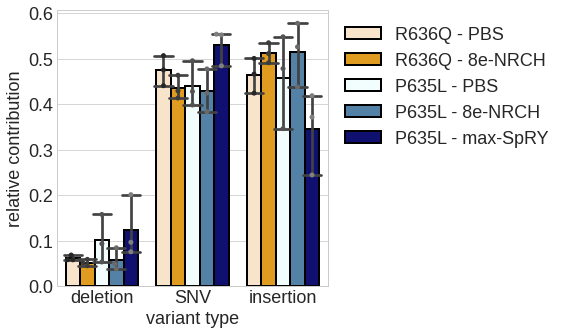

In [13]:
fig, ax = plt.subplots(1, figsize = (5,5))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

bar = sns.barplot(x = 'variable', y = 'value', hue = 'condition' ,data = heart_df, ax = ax,edgecolor = 'black', linewidth = 2, capsize = 0.2, palette = costum_palette)
sns.swarmplot(x = 'variable', y = 'value', hue = 'condition' ,data = heart_df, ax = ax,color = 'gray', dodge = True)
ax.set_ylabel('relative contribution')
ax.set_xlabel('variant type')

fig.tight_layout()

h,l = bar.get_legend_handles_labels()

ax.legend(h[5:11],l[5:11],bbox_to_anchor = (1, 1), loc = 'upper left')
plt.show()

fig.savefig(f'{outdir}/vartype/vartype_heartspec_bar.pdf', bbox_inches = 'tight')
heart_df.to_csv(f'{outdir}/vartype/vartype_heartspec_bar.txt', index = None)